## Fig 3: Reference compound analysis

<p> This code was used to perform the analysis on the data for the "Mock Screen." During the mock screen we captured 16 technical replicates for our reference conditions. These include DMSO:DMSO, DMSO:H2O, DMSO:Empty, Empty:Empty, DMSO:Diacetyl, DMSO:Isoamyl alcohol, DMSO:2-nonanone and DMSO:1-octanol.

**The aims of the mock screen were:**</p>
1. To serve as a practice run for personell ahead of running a full scale screen with 96 compounds against the N2 lab strain.
2. To capture a large dataset for N2 response against all of our reference conditions.

In [35]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest
from skimage.io import imread
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from scipy.stats import shapiro, normaltest, kruskal, mannwhitneyu, levene


### Cleaning up the data from Mock Screen 1 (MS1)
<p>The data from the mock screen was captured on 2 different days. All compounds for MS1 were blinded and need to be unblinded before combining with the data from MS2.</p>

In [36]:
#Reading in the analysis summary for the the first mock screen day
MS1_sum = pd.read_csv('C:/Users/Emily/Documents/MS/ia/MS1.csv', index_col=0).drop(columns='Large Object')
MS1_sum.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID
0,1A,324.0,0.132867,NaN,NaN,MS1_006,3028.0,NaN
1,1B,266.0,0.044643,NaN,NaN,MS1_006,3019.0,NaN
2,1C,209.0,0.067416,NaN,NaN,MS1_006,3009.0,NaN
3,1D,343.0,-0.082508,NaN,NaN,MS1_006,3013.0,NaN
4,2A,194.0,0.793103,NaN,NaN,MS1_006,3049.0,NaN


In [37]:
#Reading in the metadata file for the first mock screen day
MS1_md = pd.read_csv('C:/Users/Emily/Documents/MS/data/MS1_metadata.csv', index_col=0)
MS1_md.head()

,Recorder,Plate ID,Different strains in each well of a single assay plate? (Y/N),Different compounds in each well of a single assay plate? (Y/N),Compound library ID,Compound Well A,Compound Well B,Compound Well C,Compound Well D,Temp (C),Humidity,Chemotaxis Start (24 hrs format),Chemotaxis End (24 hrs format),Image ID,Scanner Slot:,Scanner #,Strain Well A,Strain Well B,Strain Well C,Strain Well D
Date:,,,,,,,,,,,,,,,,,,,,
08/12/21,Emily,MS1_R1_001,N,Y,1-1,B2,B3,B4,B5,NaN,NaN,NaN,NaN,MS1_001,1,NaN,NaN,NaN,NaN,NaN
08/12/21,Hodan,MS1_R1_008,N,Y,1-2,B2,B3,B4,B5,NaN,NaN,NaN,NaN,MS1_002,4,NaN,NaN,NaN,NaN,NaN
08/12/21,Emily,MS1_R1_002,N,Y,1-1,C2,C3,C4,C5,NaN,NaN,NaN,NaN,MS1_001,2,NaN,NaN,NaN,NaN,NaN
08/12/21,Emily,MS1_R1_003,N,Y,1-1,D2,D3,D4,D5,NaN,NaN,NaN,NaN,MS1_001,3,NaN,NaN,NaN,NaN,NaN
08/12/21,EMILY,MS1_R1_004,N,Y,1-1,E2,E3,E4,E5,NaN,NaN,NaN,NaN,MS1_001,4,NaN,NaN,NaN,NaN,NaN


### Cleaning up the blinding key to unblind the compounds

In [38]:
compound_data = pd.read_csv('C:/Users/Emily/Documents/MS/compounds/comp_plate_map.csv', index_col=0)

# The compound well info wass "flipped" in the original blinding key and needs to match how the data
# was entered in the metadata sheet

def flip(row):
    id = row['Compound Well']
    flipped = id[::-1]
    #print(flipped)
    return(flipped)

compound_data['Compound Well']=compound_data.apply(
    lambda row: flip(row), axis=1)


In [39]:
# Adding the plate ID to the image analysis results
def add_pid(row, image_metdat):
    slot = row['WellNo'][0]
    pid = image_metdat.loc[(image_metdat['Image ID']==row['File Name']) 
                           & (image_metdat['Scanner Slot:'].astype(str)==slot)]['Plate ID']
    return pid.values[0]

MS1_sum['Plate ID']=MS1_sum.apply(
    lambda row: add_pid(row, MS1_md), axis=1)


In [40]:
# Creating a function to map the compound info in the metadata sheet to the automated image 
# analysis results. The compound is still blinded at this point
def f(x):
    return {
        'A': 'Compound Well A',
        'B': 'Compound Well B',
        'C': 'Compound Well C',
        'D': 'Compound Well D',
    }[x]

def add_compound(row, image_metdat):
    well=row['WellNo'][1]
    dat = image_metdat.loc[image_metdat['Plate ID']==row['Plate ID']][f(well)]
    return dat.values[0]

MS1_sum['Compound']=MS1_sum.apply(
    lambda row: add_compound(row, MS1_md), axis=1)


In [41]:
# The following unblinds the compound data
def unblind(row, image_metdat, comp_dat):
    comp_plate = image_metdat.loc[image_metdat['Plate ID'] == row['Plate ID']]['Compound library ID']
    
    comp_name = comp_dat.loc[(comp_dat['Compound Well'] == row['Compound']) & 
                             (comp_dat['Plate Number'] == comp_plate.values[0])]['Compounds']
    return comp_name.values[0]


MS1_sum['Compound']=MS1_sum.apply(
    lambda row: unblind(row, MS1_md, compound_data), axis=1)

# We used 1-octanol instead of benzaldehyde. 
MS1_sum=MS1_sum.replace('Benz', '1-Oct')
MS1_sum.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID
0,1A,324.0,0.132867,EMT,NaN,MS1_006,3028.0,MS1_R1_013
1,1B,266.0,0.044643,1-Oct,NaN,MS1_006,3019.0,MS1_R1_013
2,1C,209.0,0.067416,EMT,NaN,MS1_006,3009.0,MS1_R1_013
3,1D,343.0,-0.082508,DI,NaN,MS1_006,3013.0,MS1_R1_013
4,2A,194.0,0.793103,DI,NaN,MS1_006,3049.0,MS1_R1_014


### Cleaning up the data from the 2nd mock screen day (MS2)

In [42]:
MS2_sum = pd.read_csv('C:/Users/Emily/Documents/MS/ia/MS2.csv', index_col=0)
MS2_md = pd.read_csv('C:/Users/Emily/Documents/MS/data/MS2_md.csv', index_col=0)

#An extra column for the scanner slot accidently made it into the metadata sheet. Removing
# to avoid confusion

MS2_md = MS2_md.drop(columns=['Scanner Slot'])
MS2_sum = MS2_sum.drop(columns = ['Large Object'])
MS2_sum = MS2_sum.replace('MT', 'MT_MT')

MS2_sum['Plate ID']=MS2_sum.apply(
    lambda row: add_pid(row, MS2_md), axis=1)

MS2_sum.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID
0,1A,219,0.193548,MT_MT,NaN,MS2_001,3012,MS2_R1_1
1,1B,215,-0.021739,MT_MT,NaN,MS2_001,3018,MS2_R1_1
2,1C,262,0.009091,MT_MT,NaN,MS2_001,3034,MS2_R1_1
3,1D,232,-0.049020,MT_MT,NaN,MS2_001,3028,MS2_R1_1
4,2A,194,-0.024691,MT_MT,NaN,MS2_001,3064,MS2_R1_2


### We can now combine the two mock screen summary datasets

In [43]:
analysis_data = pd.concat([MS1_sum, MS2_sum])
print(len(analysis_data))

128


In [44]:
IA_chemoidx = analysis_data.loc[analysis_data['Compound']== 'IA']['Chemotaxis'].mean()
DI_chemoidx = analysis_data.loc[analysis_data['Compound']== 'DI']['Chemotaxis'].mean()
no_chemoidx = analysis_data.loc[analysis_data['Compound']== '2no']['Chemotaxis'].mean()
print('IA: ' + str(IA_chemoidx) + '\nDI: ' + str(DI_chemoidx) + '\n2no: ' + str(no_chemoidx))

IA: 0.3510014800986694
DI: 0.49986866118369955
2no: -0.36674571877814194


### Combining the worm locations for all conditions from both MS1 and MS2

In [45]:
analysis_path = plb.Path('C:/Users/Emily/Documents/MS/ia/')

In [46]:
def get_worm_locs(row, wrms, result_dict, df): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound']
    xs = temp['X']
    total_worms = len(xs)
    mean_pos = xs.mean()
    df.loc[len(df.index)] = [compound, mean_pos, total_worms] 
    
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict, df

ref_dict = {}
mean_df = pd.DataFrame(columns=['Condition', 'MeanPos', 'TotalWorms'])
for index, row in analysis_data.iterrows():
    ref_locs, means = get_worm_locs(row, analysis_path, ref_dict, mean_df)
ref_df = pd.DataFrame.from_dict(ref_dict)
ref_df.head()

,EMT,1-Oct,DI,DMSO,IA,2no,MT_MT,DMSO_H2O
0,2078,2681.0,2329.0,1201.0,405.0,2061.0,2277.403509,2426.912467
1,1803,2309.0,1952.0,1406.0,482.0,1448.0,1669.698039,2648.373684
2,1740,1884.0,2377.0,2240.0,1320.0,1354.0,1886.927273,2185.078212
3,2023,1348.0,1891.0,808.0,886.0,687.0,552.927184,1989.336538
4,368,1329.0,2137.0,2674.0,1356.0,1078.0,1193.569444,1139.697987


### Cleaning up the headers and converting the values from dpi to milimeters

In [47]:
ref_df.columns = ['DMSO:Empty', '1-octanol', 'Diacetyl', 'DMSO:DMSO', 'Isoamyl alcohol', 
                  '2-nonanone', 'Empty:Empty', 'DMSO:Water']

In [48]:


# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm
#pixels per milimeter
px_mm

mm_df = ref_df.apply(lambda x: -(x/px_mm)+32.5)


#mm_df.to_csv('C:/Users/Emily/Documents/MS/data/wormX_ref_comps.csv')
#ref_df = pd.read_csv('D:/_2021_08_screen/practice_run/wormX_ref_comps.csv')

### Tidying up the mean position data and anlysis for each technical replicate

In [49]:
means['MeanPos'] = means['MeanPos'].apply(lambda x: -(x/px_mm)+32.5)

means = means.replace({'EMT':'DMSO:Empty' , '1-Oct': '1-octanol', 'DI':'Diacetyl',
                          'DMSO':'DMSO:DMSO', 'IA':'Isoamyl alcohol', '2no':'2-nonanone',
                          'MT_MT':'Empty:Empty','DMSO_H2O':'DMSO:Water'})

order = ['DMSO:DMSO', 'DMSO:Water', 'DMSO:Empty', 'Empty:Empty', 'Isoamyl alcohol', 'Diacetyl',
        '2-nonanone', '1-octanol']

means['Condition'] = pd.Categorical(means['Condition'], order)
means.sort_values(by=['Condition'], inplace=True)

means.head()

,Condition,MeanPos,TotalWorms
39,DMSO:DMSO,-0.570825,172
88,DMSO:DMSO,1.987777,291
79,DMSO:DMSO,-3.042001,147
72,DMSO:DMSO,1.160442,266
68,DMSO:DMSO,-2.933436,97


In [50]:
# reindexing
idex = list(np.arange(0,16,1))
idex_r = idex*8
means['idex'] = idex_r
means_piv = means.pivot(index='idex', columns='Condition', values='MeanPos')

In [51]:
means.head()

,Condition,MeanPos,TotalWorms,idex
39,DMSO:DMSO,-0.570825,172,0
88,DMSO:DMSO,1.987777,291,1
79,DMSO:DMSO,-3.042001,147,2
72,DMSO:DMSO,1.160442,266,3
68,DMSO:DMSO,-2.933436,97,4


In [52]:
means.to_csv('C:/Users/Emily/Desktop/refcomp_means.csv')

In [53]:
def cohensD(g1, g2, df):
    condition = g2['Condition'].unique().astype(str)[0]
    g1m, g2m = g1['MeanPos'], g2['MeanPos']
    meandiff = g2m.mean() - g1m.mean()
    n1, n2 = len(g1), len(g2)
    st1, st2 = statistics.variance(g1m), statistics.variance(g2m)
    pooled_var = math.sqrt(((n1-1)*st1)+((n2-1)*st2)/(n1+n2-2))
    d = meandiff / pooled_var
    df.loc[len(df)] = [condition, g2m.mean(), st2, d]
    return df

In [54]:
dmso = means.loc[means['Condition'] == 'DMSO:DMSO']
dmso_water = means.loc[means['Condition'] == 'DMSO:Water']
dmso_mt = means.loc[means['Condition'] == 'DMSO:Empty']
mt = means.loc[means['Condition'] == 'Empty:Empty']
ia = means.loc[means['Condition'] == 'Isoamyl alcohol']
di =means.loc[means['Condition'] == 'Diacetyl']
no = means.loc[means['Condition'] == '2-nonanone']
oc = means.loc[means['Condition'] == '1-octanol']

In [55]:
ref_cd = pd.DataFrame(columns=['Condition', 'Mean of means', 'StDev of means', 'CohensD'])
ref_cd

,Condition,Mean of means,StDev of means,CohensD


In [56]:
all_refs = [dmso_water, dmso_mt, mt, ia, di, no, oc]

for i in all_refs:
    ds4 = cohensD(dmso, i, ref_cd)



### Calculating the bootstrapped 95% confidence intervals for the mean difference between each condition relative to DMSO:DMSO

In [57]:
# The compounds need to be passed as a list in the order of desired appearance to dabest
ref_comps=['DMSO:DMSO', 'DMSO:Water', 'DMSO:Empty', 'Empty:Empty', 'Isoamyl alcohol', 'Diacetyl', 
           '2-nonanone', '1-octanol']
# Creating a color map to be passed to the plotting function
color_dict={'DMSO:DMSO':'#AF7AC5', 'DMSO:Empty':'#AF7AC5', 'Empty:Empty':'#AF7AC5','DMSO:Water':'#AF7AC5',
            'Diacetyl':'#66c2a5', 'Isoamyl alcohol':'#66c2a5', '1-octanol':'#fdae61', '2-nonanone':'#fdae61'}
# You need to load the data into dabest in order to use their plotting function
# Simply pass the dataframe and the ordered list of compounds
mm_refs_obj = dabest.load(mm_df, idx=(ref_comps))

In [58]:
cs = ['control_N', 'test_N', 'effect_size', 'ci','is_paired','bca_high','bca_low', 'bca_interval_idx', 'pct_low', 'pct_high',
      'pct_interval_idx', 'bootstraps', 'resamples', 'random_seed', 'pvalue_permutation',
      'permutation_count', 'pvalue_welch', 'statistic_welch', 'pvalue_students_t', 'statistic_students_t', 
      'pvalue_mann_whitney', 'statistic_mann_whitney']

In [59]:
pooled_results = mm_refs_obj.mean_diff.results
pooled_results = pooled_results.round(5)
pooled_results['Pooled confidence interval'] = list(zip(pooled_results['bca_low'], pooled_results['bca_high']))
p = pooled_results.drop(columns=cs)
p = p.rename(columns={"control":"Control", "test": "Test", "difference": "Pooled mean difference"})
p.head()
#p.to_csv('/Users/Emily/Desktop/ReviewerResponses/pooled_refs.csv')

,Control,Test,Pooled mean difference,permutations,permutations_var,Pooled confidence interval
0,DMSO:DMSO,DMSO:Water,-1.19684,"[-0.20724827954581648, -0.07948390877033862, 0...","[0.1655463678285251, 0.16534082464999594, 0.16...","(-2.00133, -0.39955)"
1,DMSO:DMSO,DMSO:Empty,-1.02967,"[-0.7204821348614538, 0.0337884304906908, 0.29...","[0.15931258634394174, 0.15924358788895535, 0.1...","(-1.79433, -0.27471)"
2,DMSO:DMSO,Empty:Empty,1.42630,"[-0.5024444625356821, -0.45861458834392804, 0....","[0.16645657243395645, 0.16559463511493513, 0.1...","(0.66375, 2.21264)"
3,DMSO:DMSO,Isoamyl alcohol,7.55021,"[-0.12158628836640295, -0.5209453236846486, 0....","[0.21728137218068638, 0.21558128319917197, 0.2...","(6.65403, 8.45343)"
4,DMSO:DMSO,Diacetyl,8.69772,"[0.0626688734105274, -0.1824640270919029, -0.3...","[0.19305172026271322, 0.19357687662974654, 0.1...","(7.89195, 9.54978)"


In [60]:
means_obj = dabest.load(means_piv, idx=ref_comps)
means16_plot = means_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm locations(mm)', 
                                        contrast_label="Mean difference (mm)", es_marker_size=2.5, contrast_ylim = (-15,15), swarm_ylim=(-35,35), custom_palette=color_dict)

#Accessing plot axes to control plot asthetics
rawswarm_axes = means16_plot.axes[0]
contrast_axes = means16_plot.axes[1]

#rawswarm_axes.yaxis.set_tick_params(tickdir='in')
#rawswarm_axes.xaxis.set_tick_params(tickdir='in')
rawswarm_axes.remove()

contrast_axes.yaxis.set_tick_params(tickdir='in')
contrast_axes.xaxis.set_tick_params(tickdir='in')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('C:/Users/Emily/Desktop/16meanPos.svg')

In [61]:
means_results = means_obj.mean_diff.results
means_results = means_results.round(5)
means_results['Confidence interval'] = list(zip(means_results['bca_low'], means_results['bca_high']))
ms = means_results.drop(columns=cs)
ms = ms.rename(columns={"control":"Control", "test": "Test", "difference": "Mean difference"})
msp = pd.concat([ms, p], axis=1)

msp.to_csv('/Users/Emily/Desktop/ReviewerResponses/pooled_analysis.csv')

In [62]:
# Generating the plots
mm_refs_plot = mm_refs_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm locations(mm)', 
                                        es_marker_size=2.5, contrast_label="Mean difference (mm)", contrast_ylim = (-15,15), swarm_ylim=(-35,35), custom_palette=color_dict)

#Accessing plot axes to control plot asthetics
rawswarm_axes = mm_refs_plot.axes[0]
contrast_axes = mm_refs_plot.axes[1]
rawswarm_axes.scatter(means.Condition, means.MeanPos, s=3,c='black', alpha = .5)

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in')

contrast_axes.yaxis.set_tick_params(tickdir='in')
contrast_axes.xaxis.set_tick_params(tickdir='in')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('C:/Users/Emily/Desktop/meanPos.svg')
#contrast_axes.remove()

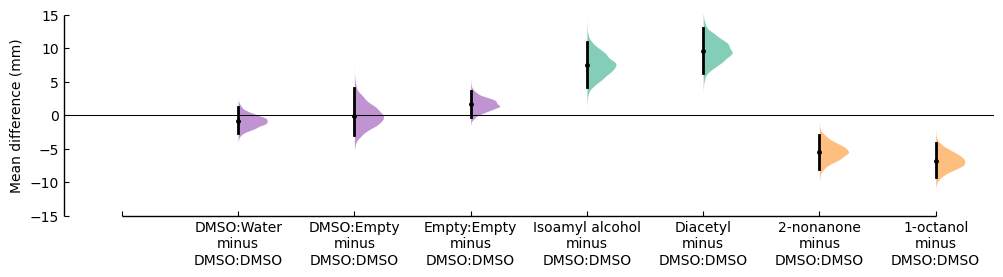

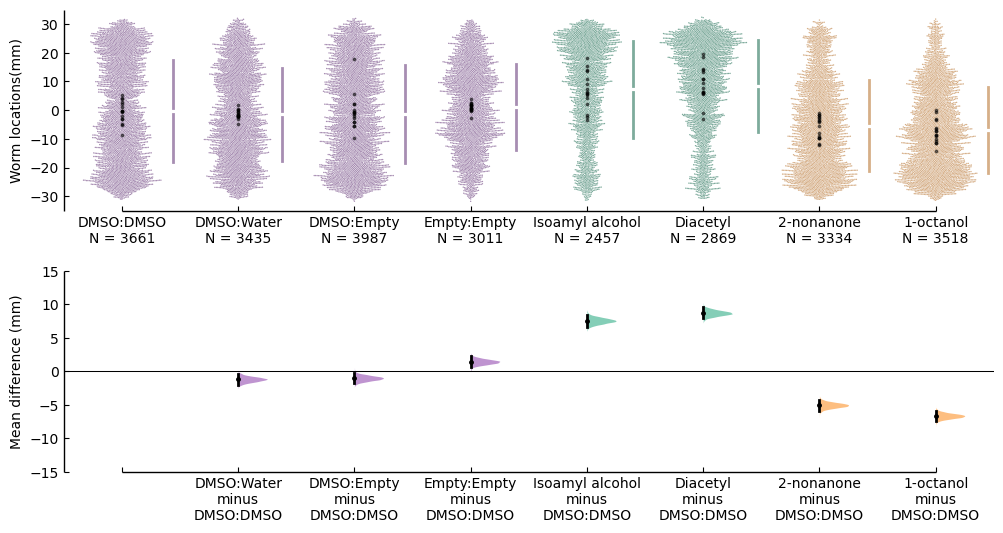

In [63]:
plt.show()

### Performing additional statistical analysis on the reference compound dataset

1. Checking to see if the worm locations are normally distributed using the Shapiro-Wilkes test.

In [13]:
for column in mm_df.columns:
    dat = mm_df[column]
    length = len(mm_df[column])- len(mm_df[mm_df[column].isnull()])
    data = mm_df[column][:length]
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

Statistics=0.955, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.959, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.927, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.942, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.927, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.957, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.979, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


2. We see that the worm location data for each reference condition is non-normally distributed.

In [14]:
c = {}
for column in mm_df.columns:

    dat = mm_df[column]
    length = len(mm_df[column])- len(mm_df[mm_df[column].isnull()])
    data = mm_df[column][:length]
    d = {column: data}
    c.update(d)

    


3. The variances in worm response to each reference condition are not equal given the low p-value of 7.77 e-79
4. Since the data is non-normally distributed, we are performing the Kruskal-Wallace test instead of ANOVA. The test below is specifically comparing the null conditions to each other: Diacetyl and Isoamyl alcohol, 2-nonanone and 1-octanol, DMSO:DMSO and Empty:Empty

In [15]:
print('Null results: ' + str(kruskal(c['DMSO:DMSO'],  c['Empty:Empty'])))
print('Null homogeneity of var: ' + str(levene(c['DMSO:DMSO'], c['DMSO:Empty'], c['DMSO:Water'],c['Empty:Empty'] )))
print('Attraction: ' + str(kruskal(c['Diacetyl'], c['Isoamyl alcohol'])))
print('Attraction varianaces: ' + str(levene(c['Diacetyl'], c['Isoamyl alcohol'])))
print('Repulsion: ' +  str(kruskal(c['1-octanol'], c['2-nonanone'])))
print('Repulsion variances: ' +  str(levene(c['1-octanol'], c['2-nonanone'])))

Null results: KruskalResult(statistic=12.947335522752496, pvalue=0.00032037715466033976)
Null homogeneity of var: LeveneResult(statistic=77.37042945197483, pvalue=1.234364245344246e-49)
Attraction: KruskalResult(statistic=3.5382500913054047, pvalue=0.05996869746010143)
Attraction varianaces: LeveneResult(statistic=13.502673218595378, pvalue=0.00024056616446977073)
Repulsion: KruskalResult(statistic=13.059113743322065, pvalue=0.00030181221293048736)
Repulsion variances: LeveneResult(statistic=21.424776268657745, pvalue=3.7476356724602016e-06)


5. We see from the results that we reject the null hypothesis that the two population medians are equal for 2 of the 3 tests. The compounds for which we should not observe attraction or repulsion do not have do not have equal medians. Similarly the compounds for which we would expect N2 to be repulsed by do not have equal medians. It should be noted that the p-value in both of these cases is not strikingly low, inboth cases p = .0003. We do see that the median response between populations to the attractive compounds is similar, p > .05. 